# The influence of dataset biases on ML fairness

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as p9

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import TransformerMixin
from transformer import DataSelector

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.base import clone

import os
import warnings
from platform import python_version

In [2]:
print("Used python version: 3.9.7. Got:", python_version())
warnings.simplefilter(action = 'ignore', category = FutureWarning)  

Used python version: 3.9.7. Got: 3.9.7


## 1. Import and prepare datasets

In [3]:
def standardize(df, attr, priv_group, unpriv_group, target, class_0 = [], class_1 = []):
    """Label the priviliged group as 1 and the unpriviliged group as 0."""
    
    for unpriv in unpriv_group:
        df[attr].replace(unpriv, "unpriv", inplace = True)
    for priv in priv_group: 
        df[attr].replace(priv, "priv", inplace = True)
    
    for c_0 in class_0:
        df[target].replace(c_0, 0, inplace = True)
    for c_1 in class_1:
        df[target].replace(c_1, 1, inplace = True)
    
    df.rename(columns = {attr : "PRTCTD_ATTR"}, inplace = True)
    df.rename(columns = {target : "CLASS"}, inplace = True)

    return df

def show_ratio(df, x_label_1, xtick_label_1, x_label_2, xtick_label_2, legend = ["Female", "Male"]):
    """Plot ratio of unprivileged group."""

    fig, (ax1, ax2) = plt.subplots(1, 2)
    d1 = df["PRTCTD_ATTR"].value_counts(normalize = True)
    p1 = d1.plot(kind = 'bar', rot = 0, sort_columns = True, ax = ax1)
    p1.set(xlabel = x_label_1, ylabel = "PERCENTAGE", xticklabels = xtick_label_1)
    
    d2 = df.groupby(["CLASS", "PRTCTD_ATTR"]).size().unstack().apply(lambda x: x / df.shape[0])
    p2 = d2.plot(kind = 'bar', rot = 0, sort_columns = True, ax = ax2)
    p2.set(xlabel = x_label_2, ylabel = "PERCENTAGE", xticklabels = xtick_label_2)
    p2.legend(legend)

    plt.tight_layout() 

### 1.1 Adult Income Dataset
Classifies whether a person earns more than 50k or not. 
<br>
Source: https://archive.ics.uci.edu/ml/datasets/adult

,age,workclass,final-weight,education-num,marital-status,occupation,relationship,race,PRTCTD_ATTR,capital-gain,capital-loss,hours-per-week,native-country,CLASS
45170,33,Private,245211,13,Never-married,Prof-specialty,Own-child,White,priv,0,0,40,United-States,0
45171,39,Private,215419,13,Divorced,Prof-specialty,Not-in-family,White,unpriv,0,0,36,United-States,0
45172,38,Private,374983,13,Married-civ-spouse,Prof-specialty,Husband,White,priv,0,0,50,United-States,0
45173,44,Private,83891,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,priv,5455,0,40,United-States,0
45174,35,Self-emp-inc,182148,13,Married-civ-spouse,Exec-managerial,Husband,White,priv,0,0,60,United-States,1


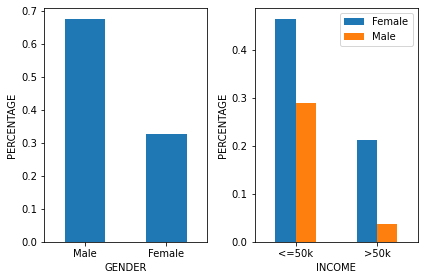

In [4]:
file_name_train = "adult.data"                            
file_name_test  = "adult.test"
protected_attr  = "sex" 
priv_group      = ["Male"]
unpriv_group    = ["Female"]
target          = "class"

features = ["age", "workclass", "final-weight","education", "education-num", "marital-status"
            , "occupation", "relationship","race", "sex", "capital-gain", "capital-loss"
            , "hours-per-week", "native-country", "class"]   

df_adult_train = pd.read_csv("Datasets\\" + file_name_train, names = features
                              , sep = r'\s*,\s*', engine = "python", na_values = '?')   
df_adult_test  = pd.read_csv("Datasets\\" + file_name_test, names = features
                              , sep = r'\s*,\s*', engine = "python", na_values = '?')
df_adult = pd.concat([df_adult_train, df_adult_test])
df_adult.reset_index(drop = True, inplace = True)                 # train and test data share same indices

standardize(df_adult, protected_attr, priv_group, unpriv_group, target, ["<=50K", "<=50K."], [">50K", ">50K."])


# customized preprocessing
df_adult.drop("education", axis = 1, inplace = True)              # drops redundant column
df_adult.dropna(axis = 0, how = "any", inplace = True)            # drops 7% of data
df_adult.drop_duplicates(inplace = True, ignore_index = True)     # drops 0.1% of data 
df_adult.reset_index(drop = True, inplace = True)

# display dataset
display(df_adult.tail())
show_ratio(df_adult, "GENDER", ["Male", "Female"], "INCOME", ["<=50k", ">50k"])

### 1.2 German Credit Dataset

Classifies people as good or bad credit risks. <br>
Source: https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data) 

,status existing account,duration,credit history,purpose,credit amount,savings,employment since,installment rate,PRTCTD_ATTR,other debtors,...,property,age,installment plans,housing,num existing credits,job,no of people liable,telephone,foreign worker,CLASS
995,A14,12,A32,A42,1736,A61,A74,3,unpriv,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,0
996,A11,30,A32,A41,3857,A61,A73,4,priv,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,0
997,A14,12,A32,A43,804,A61,A75,4,priv,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,0
998,A11,45,A32,A43,1845,A61,A73,4,priv,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,1
999,A12,45,A34,A41,4576,A62,A71,3,priv,A101,...,A123,27,A143,A152,1,A173,1,A191,A201,0


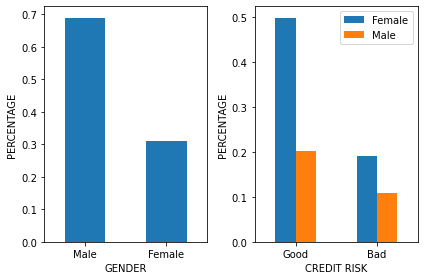

In [5]:
file_name       = "german.data"                            
protected_attr  = "sex" 
priv_group      = ["A91", "A93", "A94"]    # male
unpriv_group    = ["A92", "A95"]           # female
target          = "class"

features = ["status existing account","duration", "credit history", "purpose", "credit amount", "savings"
            , "employment since", "installment rate", "sex", "other debtors", "residence since", "property"
            , "age", "installment plans", "housing", "num existing credits", "job", "no of people liable"
            , "telephone", "foreign worker", "class"]

df_german = pd.read_csv("Datasets\\" + file_name, names = features
                              , sep = r'\s+', engine = "python")
standardize(df_german, protected_attr, priv_group, unpriv_group, target, [1], [2])    # 1 = good, 2 = bad

# display dataset
display(df_german.tail())
show_ratio(df_german, "GENDER", ["Male", "Female"], "CREDIT RISK", ["Good", "Bad"])

### 1.3 Default of credit card clients dataset
Classify whether a person's credit card has defaulted. <br>
Source: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

,X1,PRTCTD_ATTR,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,CLASS
29960,220000,priv,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29961,150000,priv,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29962,30000,priv,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29963,80000,priv,3,1,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1
29964,50000,priv,2,1,46,0,0,0,0,0,...,36535,32428,15313,2078,1800,1430,1000,1000,1000,1


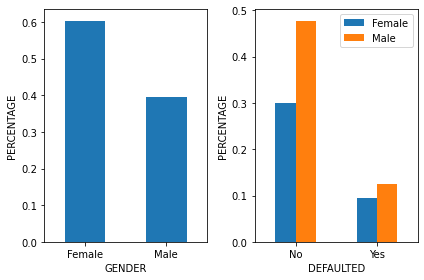

In [6]:
file_name       = "default of credit.xls"                          
protected_attr  = "X2"                   
priv_group      = [1]    # male
unpriv_group    = [2]    # female   
target          = "Y"

df_default = pd.read_excel("Datasets\\" + file_name,
                           dtype = {"X1": int, "X2": object, "X3": object, "X4": object, "X5": int, "X6": object,
                                  "X7": object, "X8": object, "X9": object, "X10": object, "X11": object, "X12": int, 
                                  "X13": int, "X14": int, "X15": int, "X16": int, "X17": int, "X23": int, "X18": int, 
                                  "X19": int, "X20": int, "X21": int, "X22": int
                                   }
                          )
standardize(df_default, protected_attr, priv_group, unpriv_group, target)     # yes = 1, no = 0

# custom transformations
df_default.drop_duplicates(inplace = True, ignore_index = True)               # drops 0.1% data      

# display dataset
display(df_default.tail())
show_ratio(df_default, "GENDER", ["Female", "Male"], "DEFAULTED", ["No", "Yes"])

### 1.4 Ricci vs. DeStefano dataset
Contains exam results from 118 firefighters.
<br>
Original dataset is not available. Downloaded from: https://github.com/maxkrawietz/Thesis

,PRTCTD_ATTR,Position,Oral,Written,CLASS
112,unpriv,Lieutenant,40.83,64,0.0
113,unpriv,Lieutenant,52.08,56,0.0
114,unpriv,Lieutenant,48.33,58,0.0
115,unpriv,Lieutenant,52.92,49,0.0
116,unpriv,Lieutenant,45.83,46,0.0


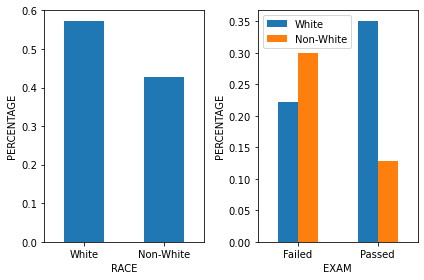

In [7]:
file_name      = "riccidata.csv"
protected_attr = "Race" 
priv_group     = ['W']           # white
unpriv_group   = ['H', 'B']      # hispanic, black
target         = 'Combine"""'    # overall exam score                               

df_ricci = pd.read_csv("Datasets\\" + file_name, sep = r'"*,"*', engine = "python")
df_ricci.drop("Unnamed: 0", axis = 1, inplace = True)
df_ricci.drop("X", axis = 1, inplace = True)
df_ricci['Combine"""'].replace(to_replace = r'"$', value = '', regex = True, inplace = True)
df_ricci['Combine"""'] = df_ricci['Combine"""'].astype(float, copy = True)

standardize(df_ricci, protected_attr, priv_group, unpriv_group, target)  

# customized preprocessing 
df_ricci.drop_duplicates(inplace = True, ignore_index = True)      # drops 0.8% of data
df_ricci.loc[(df_ricci["CLASS"] < 70), "CLASS"] = 0  
df_ricci.loc[df_ricci["CLASS"]>= 70, "CLASS"] = 1  

# display data
display(df_ricci.tail())
show_ratio(df_ricci, "RACE", ["White", "Non-White"], "EXAM", ["Failed", "Passed"], ["White", "Non-White"])
#show_ratio(df_ricci, "RACE", ["White", "Non-White"], "EXAM", ["Passed", "Failed"], ["White", "Non-White"])

### 1.5 Heart Disease Dataset
Predicts the presence of heart disease in the patient.
<br>
Source: https://archive.ics.uci.edu/ml/datasets/heart+disease

,1,PRTCTD_ATTR,3,4,5,6,7,8,9,10,11,12,13,CLASS
297,57.0,unpriv,asymptomatic,140.0,241.0,0.0,normal,123.0,1.0,0.2,flat,0.0,reversable,1
298,45.0,priv,typical angina,110.0,264.0,0.0,normal,132.0,0.0,1.2,flat,0.0,reversable,1
299,68.0,priv,asymptomatic,144.0,193.0,1.0,normal,141.0,0.0,3.4,flat,2.0,reversable,1
300,57.0,priv,asymptomatic,130.0,131.0,0.0,normal,115.0,1.0,1.2,flat,1.0,reversable,1
301,57.0,unpriv,atypical angina,130.0,236.0,0.0,hypertrophy,174.0,0.0,0.0,flat,1.0,normal,1


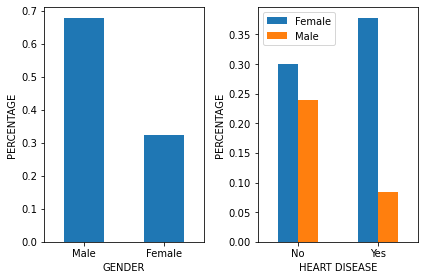

In [8]:
file_name       = "processed.cleveland.data"
protected_attr = '2'
priv_group     = [1]   # males
unpriv_group   = [0]   # females
target         = '14'

features = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12' ,'13', '14']

df_disease = pd.read_csv("Datasets\\" + file_name, names = features, na_values = '?')
standardize(df_disease, protected_attr, priv_group, unpriv_group, target, [0], [1, 2, 3, 4])  

# custom transformations
df_disease.dropna(how = 'any', inplace = True)    # drops 2% of data

df_disease.loc[df_disease['3'] == 1, '3'] = "typical angina"
df_disease.loc[df_disease['3'] == 2, '3'] = "atypical angina"
df_disease.loc[df_disease['3'] == 3, '3'] = "non-anginal pain"
df_disease.loc[df_disease['3'] == 4, '3'] = "asymptomatic"

df_disease.loc[df_disease['7'] == 0, '7'] = "normal"
df_disease.loc[df_disease['7'] == 1, '7'] = "ST-T wave"
df_disease.loc[df_disease['7'] == 2, '7'] = "hypertrophy"

df_disease.loc[df_disease['11'] == 1, '11'] = "upsloping"
df_disease.loc[df_disease['11'] == 2, '11'] = "flat"
df_disease.loc[df_disease['11'] == 3, '11'] = "downsloping"

df_disease.loc[df_disease['13'] == 3, '13'] = "normal"
df_disease.loc[df_disease['13'] == 6, '13'] = "fixed"
df_disease.loc[df_disease['13'] == 7, '13'] = "reversable"

# display data
display(df_disease.tail())
show_ratio(df_disease, "GENDER", ["Male", "Female"], "HEART DISEASE", ["No", "Yes"])

### 1.6 Heart Failure Dataset
Contains the medical records of 299 patients who had heart failure, collected during their follow-up period.
<br>
Source: https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,PRTCTD_ATTR,smoking,time,CLASS
294,62.0,0,61,1,38,1,155000.0,1.1,143,priv,1,270,0
295,55.0,0,1820,0,38,0,270000.0,1.2,139,unpriv,0,271,0
296,45.0,0,2060,1,60,0,742000.0,0.8,138,unpriv,0,278,0
297,45.0,0,2413,0,38,0,140000.0,1.4,140,priv,1,280,0
298,50.0,0,196,0,45,0,395000.0,1.6,136,priv,1,285,0


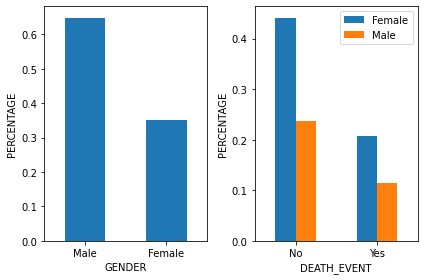

In [9]:
file_name       = "heart_failure.csv"
protected_attr = "sex"
priv_group     = [1]   # males
unpriv_group   = [0]   # females
target         = "DEATH_EVENT"

df_failure = pd.read_csv("Datasets\\" + file_name)
standardize(df_failure, protected_attr, priv_group, unpriv_group, target)

# display data
display(df_failure.tail())
show_ratio(df_failure, "GENDER", ["Male", "Female"], "DEATH_EVENT", ["No", "Yes"])

### 1.7 Student Performance Dataset
Predict high school student performance for subject "Portugese".
<br>
Source: https://archive.ics.uci.edu/ml/datasets/student+performance

,school,PRTCTD_ATTR,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,CLASS
644,MS,unpriv,19,R,GT3,T,2,3,services,other,...,yes,no,5,4,2,1,2,5,4,1
645,MS,unpriv,18,U,LE3,T,3,1,teacher,services,...,yes,no,4,3,4,1,1,1,4,1
646,MS,unpriv,18,U,GT3,T,1,1,other,other,...,no,no,1,1,1,1,1,5,6,0
647,MS,priv,17,U,LE3,T,3,1,services,services,...,yes,no,2,4,5,3,4,2,6,1
648,MS,priv,18,R,LE3,T,3,2,services,other,...,yes,no,4,4,1,3,4,5,4,1


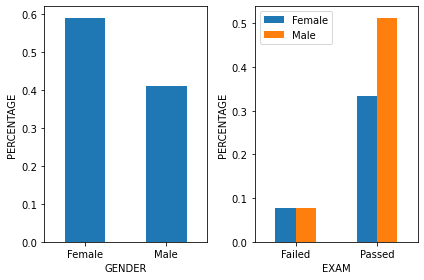

In [10]:
file_name      = "student-por.csv"
protected_attr = "sex"
priv_group     = ["M"]
unpriv_group   = ["F"]
target         = "G3"

df_student = pd.read_csv("Datasets\\" + file_name, sep = ';')
standardize(df_student, protected_attr, priv_group, unpriv_group, target, list(range(0, 10)), list(range(10, 21)))

# custom transformations
df_student.drop(["G1", "G2"], axis = 1, inplace = True)    # drop redundant information

# display data
display(df_student.tail())
show_ratio(df_student, "GENDER", ["Female", "Male"], "EXAM", ["Failed", "Passed"])

## 2. Preprocess data

In [11]:
class DenseTransformer(TransformerMixin):
    "Transform sparse matrices to dense format."
    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        return X.todense()
    
cat_trans = Pipeline(steps = [
    ("selector", DataSelector("object")),
    ("one_hot", OneHotEncoder()),
    ("to_dense", DenseTransformer())
])

num_trans = Pipeline(steps = [
    ("selector", DataSelector("number")),
    ("scaler", StandardScaler() ),
])

pipe_adult = FeatureUnion(transformer_list = [
    ("cat", cat_trans),
    ("num", num_trans)
])

pipe_german = FeatureUnion(transformer_list = [
    ("cat", cat_trans),
    ("num", num_trans)
])

pipe_default = FeatureUnion(transformer_list = [
    ("cat", cat_trans),
    ("num", num_trans)
])

pipe_ricci = FeatureUnion(transformer_list = [
    ("cat", cat_trans),
    ("num", num_trans)
])

pipe_disease = FeatureUnion(transformer_list = [
    ("cat", cat_trans),
    ("num", num_trans)
])

pipe_failure = FeatureUnion(transformer_list = [
    ("cat", cat_trans),
    ("num", num_trans)
])

pipe_student = FeatureUnion(transformer_list = [
    ("cat", cat_trans),
    ("num", num_trans)
])

## 3. Train models

In [12]:
dataframes   = [df_adult, df_german, df_default, df_ricci, df_disease, df_failure, df_student]
transformers = [pipe_adult, pipe_german, pipe_default, pipe_ricci, pipe_disease, pipe_failure, pipe_student]
classifiers  = [KNeighborsClassifier(5), SVC(), GaussianNB(), DecisionTreeClassifier(random_state = 99),
                RandomForestClassifier(random_state = 99), AdaBoostClassifier(), 
                XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss')]               
ratios = [0.99, 0.9, 0.75, 0.5, 0.25, 0.1, 0.01]

data_names = ["df_adult", "df_german", "df_default", "df_ricci", "df_disease", "df_failure", "df_student"]
classifier_names = ["KNeighborsClassifier", "GaussianNB", "SVC", "DecisionTreeClassifier",
                    "RandomForestClassifier", "AdaBoostClassifier", "XGBClassifier"]

In [13]:
predictions = {}

for i in range (0, 7):                                                                                            
    dataframe_predictions = {}
    dataframe = dataframes[i].copy()
    data_name = data_names[i]
    
    transformer = transformers[i]
    transformer.fit(dataframe.drop("CLASS", axis = 1, inplace = False))  
    
    #create balanced test set and super training set
    df_0, df_1 = dataframe.loc[dataframe["PRTCTD_ATTR"] == "unpriv"], dataframe.loc[dataframe["PRTCTD_ATTR"] == "priv"]    
    tst_size = math.floor(min(df_0.shape[0], df_1.shape[0]) * 0.2)
    train_size = min(df_0.shape[0], df_1.shape[0]) - tst_size
    df_0_train, df_0_test, y0, y0_test = train_test_split(df_0.drop("CLASS", axis = 1), df_0["CLASS"],
                                                          test_size = tst_size, shuffle = True, random_state = 99             
                                                         )
    df_1_train, df_1_test, y1, y1_test = train_test_split(df_1.drop("CLASS", axis = 1), df_1["CLASS"], 
                                                          test_size = tst_size, shuffle = True, random_state = 99              
                                                         )
    
    df_test = pd.concat([df_0_test, df_1_test])
    y_test = pd.concat([y0_test, y1_test])
    out = pd.concat([df_test["PRTCTD_ATTR"], y_test], axis = 1)
    X_test = transformer.transform(df_test)
    
    for classifier in classifiers:
        clf_name = classifier.__class__.__name__
        rto_predictions = {}
        
        for rto in ratios:
            rto_predictions[rto] = out.copy()
            
            for seed in range(1, 31):     
                df_0_cop = df_0_train.copy()   
                df_1_cop = df_1_train.copy()
                # create biased training set by downsizing and upsizing the unpriv group vs. priv group
                df_0_sub = df_0_cop.sample(n = math.floor(rto * train_size), replace = False, random_state = seed)             
                df_1_sub = df_1_cop.sample(n = train_size - math.floor(rto * train_size), replace = False, random_state = seed) 
                df_train = pd.concat([df_0_sub, df_1_sub])
                y = pd.concat([y0, y1]).loc[df_train.index.to_list()]
                
                X = transformer.transform(df_train)
                
                #cv = cross_val_score(classifier, X, y, cv = 5, scoring = 'accuracy').mean()
                classifier.fit(X, y)
                pred = classifier.predict(X_test)             
                rto_predictions[rto][seed] = pred
                classifier = clone(classifier) 
                
            # to check results: rto_predictions[rto]["SUM"] = rto_predictions[rto].sum(axis = 1)
                
        dataframe_predictions[clf_name] = rto_predictions
    
    predictions[data_name] = dataframe_predictions

In [14]:
# save predictions as csv
base_dir = "..\\predictions"              
#os.makedirs(base_dir, exist_ok = True)

for data_name in data_names:
    for clf_name in classifier_names:
        path = os.path.join(base_dir, data_name + "\\" + clf_name)
        os.makedirs(path, exist_ok = True)
        for rto in ratios:
            predictions[data_name][clf_name][rto].to_csv(path + "\\" + str(rto) + ".csv")

In [15]:
# load predictions from csv
predictions = {}

for data_name in data_names:                                                                                            
    dataframe_predictions = {}
    for clf_name in classifier_names:
        rto_predictions = {}
        
        for rto in ratios:
            rto_predictions[rto] = pd.read_csv("predictions\\" + data_name + "\\" + clf_name + "\\" + str(rto) + ".csv")
                
        dataframe_predictions[clf_name] = rto_predictions
    
    predictions[data_name] = dataframe_predictions

In [16]:
predictions["df_ricci"]["KNeighborsClassifier"][0.01]

,Unnamed: 0,PRTCTD_ATTR,CLASS,1,2,3,4,5,6,7,...,21,22,23,24,25,26,27,28,29,30
0,53,unpriv,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,90,unpriv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,36,unpriv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,34,unpriv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,84,unpriv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,66,unpriv,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6,98,unpriv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,96,unpriv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,63,unpriv,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
9,111,unpriv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4. Evaluate results

### 4.1 Create confusion matrix for priv/unpriv

In [17]:
def division(n, d):
    return n / d if d != 0 else 0

In [18]:
results = {}

for data_name in data_names:
    df_results = {}

    for clf_name in classifier_names:
        rto_results = {}
        for rto in ratios:
            attr_results = {}                                                     
            df_pred = predictions[data_name][clf_name][rto]
            
            for group in ("unpriv", "priv"):   
                group_results = {}
                df_pred_attr = df_pred.loc[df_pred["PRTCTD_ATTR"] == group]
                TP, TN, FP, FN = 0, 0, 0, 0
                size, pos_pred, neg_pred = 0, 0, 0

                for i in range(1, 31):           
                    confusion = confusion_matrix(df_pred_attr["CLASS"], df_pred_attr[str(i)])
                    TP += confusion[1, 1]
                    TN += confusion[0, 0]
                    FP += confusion[0, 1]
                    FN += confusion[1, 0]
                    size += confusion.sum()

                group_results["TP"] = TP
                group_results["TN"] = TN
                group_results["FP"] = FP
                group_results["FN"] = FN
                group_results["size"] = size

                group_results["accuracy_equality"] = division((TP + TN), size)
                group_results["opportunity_equality"] = division(TP, (TP + FN))
                group_results["predictive_equality"] = division(FP, (TN + FP))
                group_results["predictive_equality"] = division(FP, (TN + FP))
                group_results["statistical_parity"] = division((TP + FP), size)
                group_results["predictive_parity"] = division(TP, (TP + FP))
                group_results["neg_predictive_parity"] = division(TN, (TN + FN))
                group_results["treatment equality"] = division(division(FP, (TN + FP)), division(FN, (TP + FN)))
                
                attr_results[group] = group_results
            
            rto_results[rto] = pd.DataFrame(attr_results)
            rto_results[rto]["SUM"] = rto_results[rto].sum(axis = 1)   # calculate sum for overall performance
            
        df_results[clf_name] = rto_results

    results[data_name] = df_results

In [19]:
results["df_ricci"]["KNeighborsClassifier"][0.99]

,unpriv,priv,SUM
TP,58.000000,184.000000,242.000000
TN,210.000000,69.000000,279.000000
FP,0.000000,21.000000,21.000000
FN,32.000000,26.000000,58.000000
size,300.000000,300.000000,600.000000
accuracy_equality,0.893333,0.843333,1.736667
opportunity_equality,0.644444,0.876190,1.520635
predictive_equality,0.000000,0.233333,0.233333
statistical_parity,0.193333,0.683333,0.876667
predictive_parity,1.000000,0.897561,1.897561


In [20]:
# save predictions as csv
base_dir = "..\\results"               
os.makedirs(base_dir, exist_ok = True)

for data_name in data_names:
    for clf_name in classifier_names:
        path = os.path.join(base_dir, data_name + "\\" + clf_name)
        os.makedirs(path, exist_ok = True)
        for rto in ratios:
            results[data_name][clf_name][rto].to_csv(path + "\\" + str(rto) + ".csv")

### 4.2 Check overall accuracy performance

In [21]:
base_dir = "..\\plots"                
os.makedirs(base_dir, exist_ok = True)

In [22]:
overall_acc = pd.DataFrame(columns = ["dataset", "classifier", "ratio", "overall_acc"])
for data_name in data_names:
    for clf_name in classifier_names:
        for rto in ratios:
            res = results[data_name][clf_name][rto]["SUM"]     
            acc = (res["TP"] + res["TN"]) / res["size"]       
            overall_acc.loc[len(overall_acc)] = [data_name, clf_name, rto, acc]

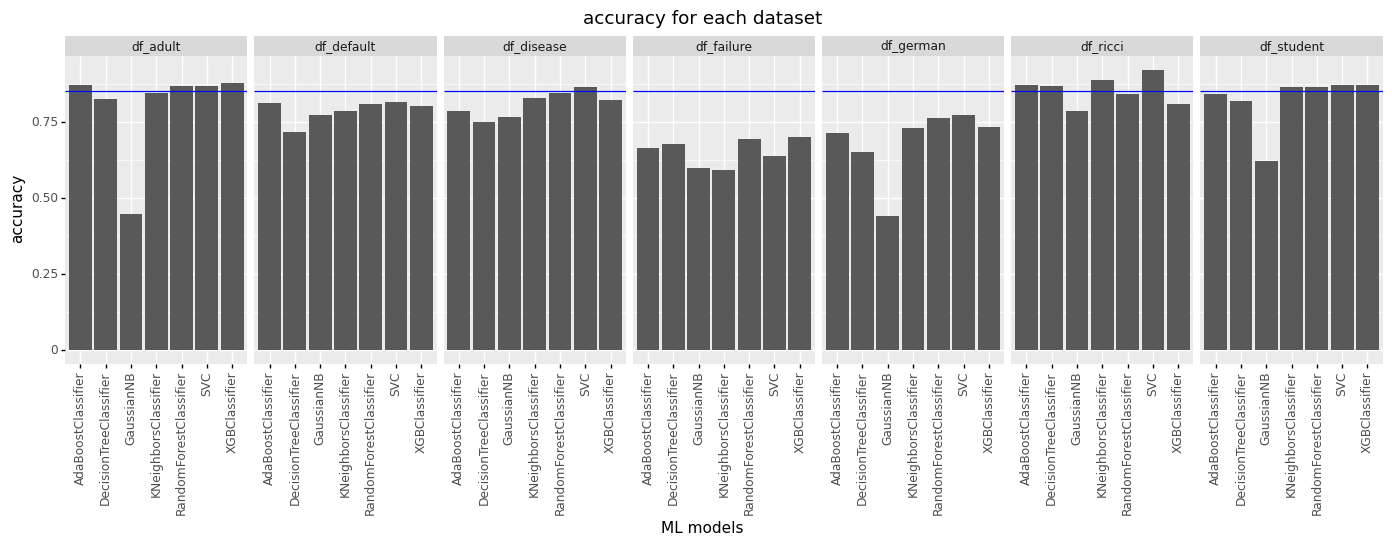

<ggplot: (166845869050)>

In [23]:
# plot accuracy per dataset per classifier averaged over all ratios  
d = overall_acc.groupby(["dataset", "classifier"], as_index = False)["overall_acc"].mean()

plot = (p9.ggplot(data = d, mapping = p9.aes(x = "classifier", y = "overall_acc")) 
        + p9.geom_col(position = "dodge")
        + p9.facet_grid(".~dataset") 
        + p9.geom_hline(yintercept = 0.85, color = "blue")
        + p9.theme(axis_text_x = p9.element_text(angle = 90), figure_size = (17, 4))
        + p9.labs(x = "ML models", y = "accuracy", title = ("accuracy for each dataset"))
        )

#plot.save(filename = "plots\\" + "overall_acc_per_data.jpg")   
plot

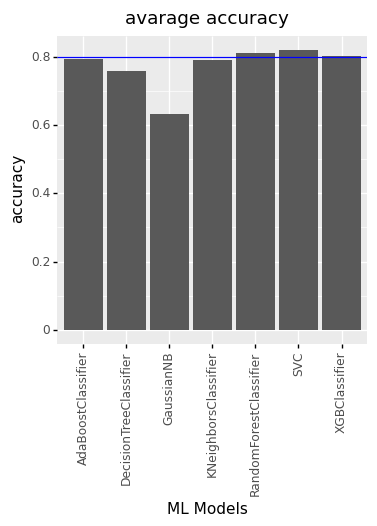

<ggplot: (166846183418)>

In [24]:
# plot accuracy for each classifier averaged over all datasets and ratios
d = overall_acc.groupby(["classifier"], as_index = False)["overall_acc"].mean()

plot = (p9.ggplot(data = d, mapping = p9.aes(x = "classifier", y = "overall_acc")) 
        + p9.geom_col(position = "dodge")
        + p9.theme(axis_text_x = p9.element_text(angle=90), figure_size = (4, 4))
        + p9.geom_hline(yintercept = 0.8, color = "blue")
        + p9.labs(x = "ML Models", y = "accuracy", title = ("avarage accuracy"))
        )

#plot.save(filename = "plots\\" + "overall_acc_per_clf.jpg")
plot

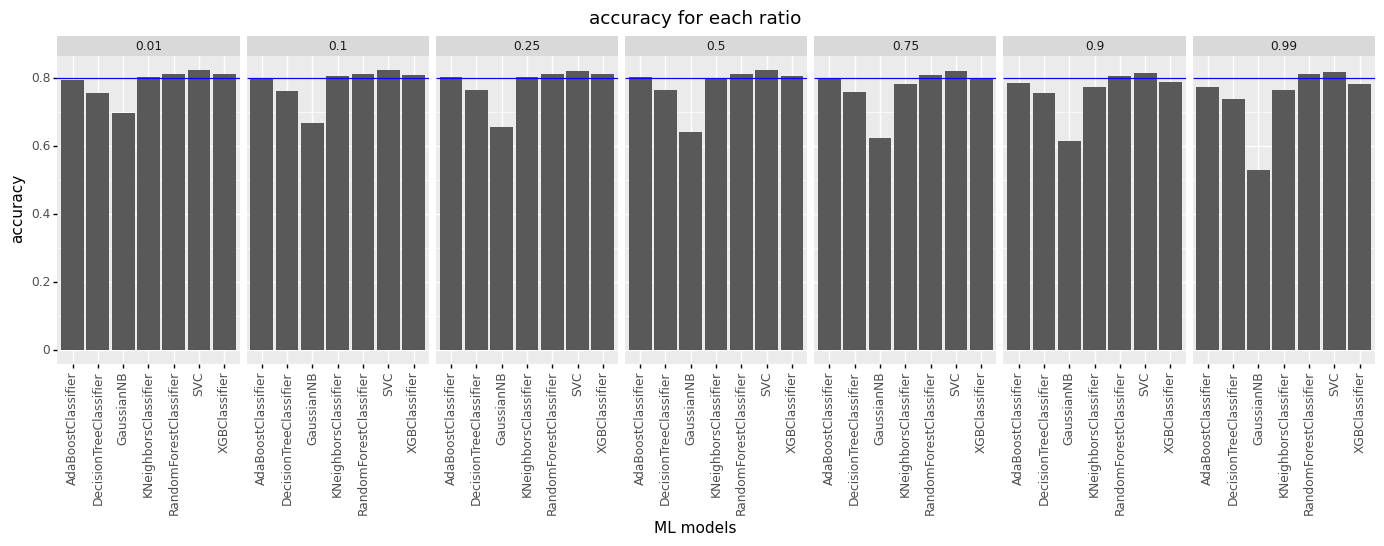

<ggplot: (166846226755)>

In [25]:
# plot accuracy per ratio per classifier
d = overall_acc.groupby(["ratio", "classifier"], as_index = False)["overall_acc"].mean()

plot = (p9.ggplot(data = d, mapping = p9.aes(x = "classifier", y = "overall_acc")) 
        + p9.geom_col(position = "dodge")
        + p9.facet_grid(".~ratio") 
        + p9.theme(axis_text_x = p9.element_text(angle = 90), figure_size = (17, 4))
        + p9.geom_hline(yintercept = 0.80, color = "blue")
        + p9.labs(x = "ML models", y = "accuracy", title = ("accuracy for each ratio"))
        )

#plot.save(filename = "plots\\" + "overall_acc_per_ratio.jpg")
plot

### 4.3 Boxplots

In [26]:
criteria = ["accuracy_equality", "opportunity_equality", "predictive_equality", "statistical_parity",
            "predictive_parity", "neg_predictive_parity", "treatment equality"]

In [27]:
rel_diff = pd.DataFrame(columns = ["dataset", "classifier", "ratio", "criterion", "diff"])

for data_name in data_names:
    for clf_name in classifier_names:
        for rto in ratios:
            for criterion in criteria:
                diff = division(results[data_name][clf_name][rto]["unpriv"][criterion],
                                results[data_name][clf_name][rto]["priv"][criterion])
                rel_diff.loc[len(rel_diff)] = [data_name, clf_name, rto, criterion, diff]

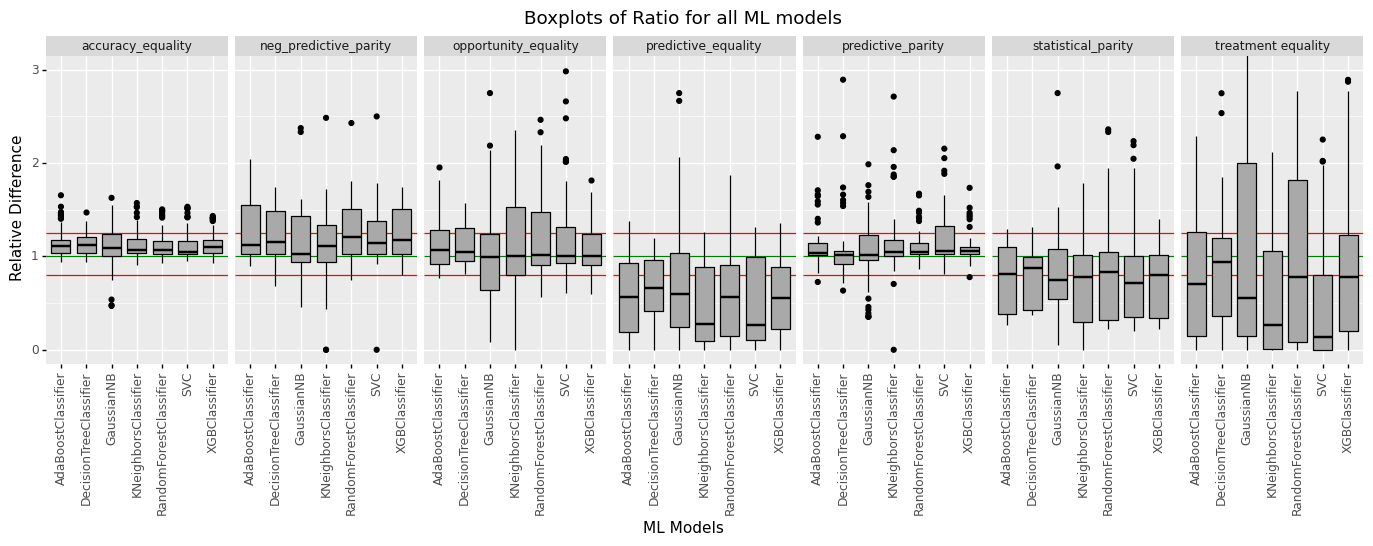

<ggplot: (166847336708)>

In [28]:
# boxplot per criterion per classifier averaged over all ratios
d = rel_diff.groupby(["criterion", "classifier"], as_index = False)["diff"]

plot = (p9.ggplot(data = d, mapping = p9.aes(x = "classifier", y = "diff"))
        + p9.geom_hline(yintercept = 0.8, color = "red")
        + p9.geom_hline(yintercept = 1, color = "green")
        + p9.geom_hline(yintercept = 1.25, color = "red")
        + p9.geom_boxplot(color = "black", fill = "darkgrey")
        + p9.coords.coord_cartesian(ylim = (0, 3))
        + p9.facet_grid(".~criterion")
        + p9.theme(axis_text_x = p9.element_text(angle = 90), figure_size = (17, 4))
        + p9.labs(x = "ML Models", y = "Relative Difference", title = ("Boxplots of Ratio for all ML models"))
        )

#plot.save(filename="plots/boxplots/boxplot_criterion_clf.jpg")    
plot

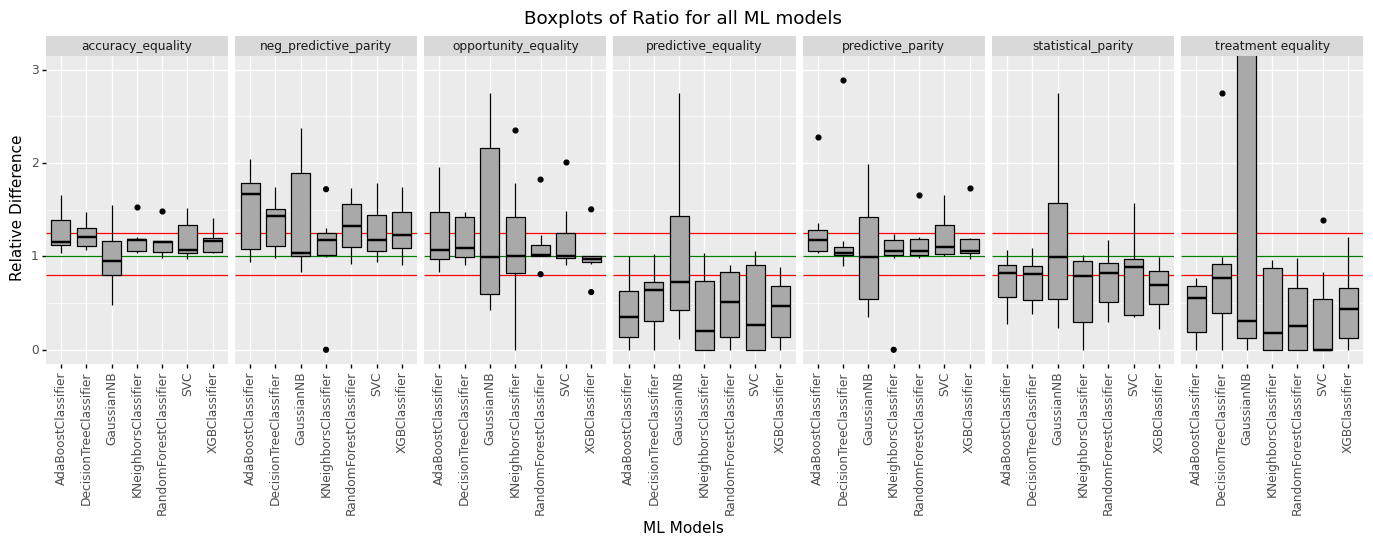

<ggplot: (166857785597)>

In [29]:
# same boxplot as above but for different ratios
rel_diff2 = rel_diff.copy()
d = rel_diff2.loc[rel_diff2["ratio"] == 0.99].groupby(["criterion", "classifier"], as_index = False)["diff"]

plot = (p9.ggplot(data = d, mapping = p9.aes(x = "classifier", y = "diff"))
        + p9.geom_hline(yintercept = 0.8, color = "red")
        + p9.geom_hline(yintercept = 1, color = "green")
        + p9.geom_hline(yintercept = 1.25, color = "red")
        + p9.geom_boxplot(color = "black", fill = "darkgrey")
        + p9.coords.coord_cartesian(ylim = (0, 3))
        + p9.facet_grid(".~criterion")#, space = "free_x", scales = "fixed")
        + p9.theme(axis_text_x = p9.element_text(angle = 90), figure_size = (17, 4))
        + p9.labs(x = "ML Models", y = "Relative Difference", title = ("Boxplots of Ratio for all ML models"))
        )

#plot.save(filename="plots/boxplots/boxplot_criterion_clf_99.jpg")  
plot

In [31]:
# same boxplot as above but for different ratios
rel_diff2 = rel_diff.copy()
d = rel_diff2.loc[rel_diff2["ratio"] == 0.9].groupby(["criterion", "classifier"], as_index = False)["diff"]

plot = (p9.ggplot(data = d, mapping = p9.aes(x = "classifier", y = "diff"))
        + p9.geom_hline(yintercept = 0.8, color = "red")
        + p9.geom_hline(yintercept = 1, color = "green")
        + p9.geom_hline(yintercept = 1.25, color = "red")
        + p9.geom_boxplot(color = "black", fill = "darkgrey")
        + p9.coords.coord_cartesian(ylim = (0, 3))
        + p9.facet_grid(".~criterion")#, space = "free_x", scales = "fixed")
        + p9.theme(axis_text_x = p9.element_text(angle = 90), figure_size = (17, 4))
        + p9.labs(x = "ML Models", y = "Relative Difference", title = ("Boxplots of Ratio for all ML models"))
        )

#plot.save(filename="plots/boxplots/boxplot_criterion_clf_90.jpg")  

In [32]:
# same boxplot as above but for different ratios
rel_diff2 = rel_diff.copy()
d = rel_diff2.loc[rel_diff2["ratio"] == 0.75].groupby(["criterion", "classifier"], as_index = False)["diff"]

plot = (p9.ggplot(data = d, mapping = p9.aes(x = "classifier", y = "diff"))
        + p9.geom_hline(yintercept = 0.8, color = "red")
        + p9.geom_hline(yintercept = 1, color = "green")
        + p9.geom_hline(yintercept = 1.25, color = "red")
        + p9.geom_boxplot(color = "black", fill = "darkgrey")
        + p9.coords.coord_cartesian(ylim = (0, 3))
        + p9.facet_grid(".~criterion")#, space = "free_x", scales = "fixed")
        + p9.theme(axis_text_x = p9.element_text(angle = 90), figure_size = (17, 4))
        + p9.labs(x = "ML Models", y = "Relative Difference", title = ("Boxplots of Ratio for all ML models"))
        )

#plot.save(filename="plots/boxplots/boxplot_criterion_clf_75.jpg")

In [33]:
# same boxplot as above but for different ratios
rel_diff2 = rel_diff.copy()
d = rel_diff2.loc[rel_diff2["ratio"] == 0.5].groupby(["criterion", "classifier"], as_index = False)["diff"]

plot = (p9.ggplot(data = d, mapping = p9.aes(x = "classifier", y = "diff"))
        + p9.geom_hline(yintercept = 0.8, color = "red")
        + p9.geom_hline(yintercept = 1, color = "green")
        + p9.geom_hline(yintercept = 1.25, color = "red")
        + p9.geom_boxplot(color = "black", fill = "darkgrey")
        + p9.coords.coord_cartesian(ylim = (0, 3))
        + p9.facet_grid(".~criterion")#, space = "free_x", scales = "fixed")
        + p9.theme(axis_text_x = p9.element_text(angle = 90), figure_size = (17, 4))
        + p9.labs(x = "ML Models", y = "Relative Difference", title = ("Boxplots of Ratio for all ML models"))
        )

#plot.save(filename="plots/boxplots/boxplot_criterion_clf_50.jpg")   

In [34]:
# same boxplot as above but for different ratios
rel_diff2 = rel_diff.copy()
d = rel_diff2.loc[rel_diff2["ratio"] == 0.25].groupby(["criterion", "classifier"], as_index = False)["diff"]

plot = (p9.ggplot(data = d, mapping = p9.aes(x = "classifier", y = "diff"))
        + p9.geom_hline(yintercept = 0.8, color = "red")
        + p9.geom_hline(yintercept = 1, color = "green")
        + p9.geom_hline(yintercept = 1.25, color = "red")
        + p9.geom_boxplot(color = "black", fill = "darkgrey")
        + p9.coords.coord_cartesian(ylim = (0, 3))
        + p9.facet_grid(".~criterion")#, space = "free_x", scales = "fixed")
        + p9.theme(axis_text_x = p9.element_text(angle = 90), figure_size = (17, 4))
        + p9.labs(x = "ML Models", y = "Relative Difference", title = ("Boxplots of Ratio for all ML models"))
        )

#plot.save(filename="plots/boxplots/boxplot_criterion_clf_25.jpg")   

In [35]:
# same boxplot as above but for different ratios
rel_diff2 = rel_diff.copy()
d = rel_diff2.loc[rel_diff2["ratio"] == 0.1].groupby(["criterion", "classifier"], as_index = False)["diff"]

plot = (p9.ggplot(data = d, mapping = p9.aes(x = "classifier", y = "diff"))
        + p9.geom_hline(yintercept = 0.8, color = "red")
        + p9.geom_hline(yintercept = 1, color = "green")
        + p9.geom_hline(yintercept = 1.25, color = "red")
        + p9.geom_boxplot(color = "black", fill = "darkgrey")
        + p9.coords.coord_cartesian(ylim = (0, 3))
        + p9.facet_grid(".~criterion")#, space = "free_x", scales = "fixed")
        + p9.theme(axis_text_x = p9.element_text(angle = 90), figure_size = (17, 4))
        + p9.labs(x = "ML Models", y = "Relative Difference", title = ("Boxplots of Ratio for all ML models"))
        )

#plot.save(filename="plots/boxplots/boxplot_criterion_clf_10.jpg")   

In [36]:
# same boxplot as above but for different ratios
rel_diff2 = rel_diff.copy()
d = rel_diff2.loc[rel_diff2["ratio"] == 0.01].groupby(["criterion", "classifier"], as_index = False)["diff"]

plot = (p9.ggplot(data = d, mapping = p9.aes(x = "classifier", y = "diff"))
        + p9.geom_hline(yintercept = 0.8, color = "red")
        + p9.geom_hline(yintercept = 1, color = "green")
        + p9.geom_hline(yintercept = 1.25, color = "red")
        + p9.geom_boxplot(color = "black", fill = "darkgrey")
        + p9.coords.coord_cartesian(ylim = (0, 3))
        + p9.facet_grid(".~criterion")#, space = "free_x", scales = "fixed")
        + p9.theme(axis_text_x = p9.element_text(angle = 90), figure_size = (17, 4))
        + p9.labs(x = "ML Models", y = "Relative Difference", title = ("Boxplots of Ratio for all ML models"))
        )

#plot.save(filename="plots/boxplots/boxplot_criterion_clf_01.jpg")  

### 4.4. Timeseries

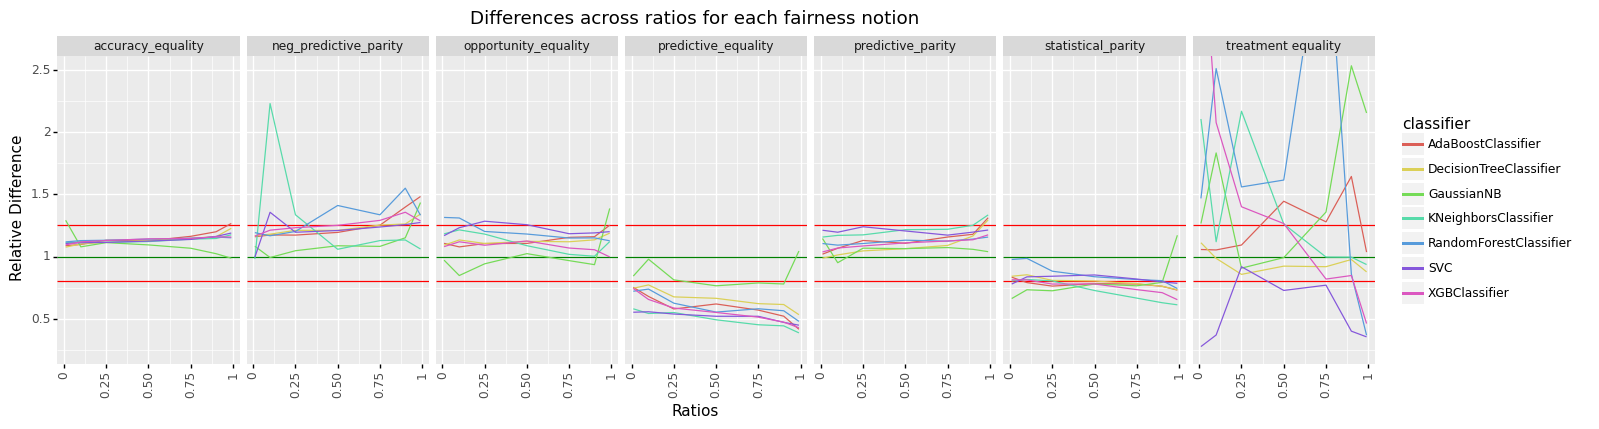

<ggplot: (166846258658)>

In [37]:
# check changes in ratio per criterion per classifier
d = rel_diff.groupby(["criterion", "classifier", "ratio"], as_index = False)["diff"].mean()

plot =  (p9.ggplot(data = d, mapping = p9.aes(x = 'ratio', y = 'diff', color = 'classifier'))
        + p9.geom_hline(yintercept = 0.8, color = "red")
        + p9.geom_hline(yintercept = 1, color = "green")
        + p9.geom_hline(yintercept = 1.25, color = "red")
        + p9.geom_line()
        #+ p9.geom_pointrange(aes(ymin = lower, ymax = upper))
        + p9.facet_grid(".~criterion")
        + p9.coords.coord_cartesian(ylim = (0.25, 2.5))
        + p9.theme(axis_text_x = p9.element_text(angle = 90), figure_size = (17, 4))
        + p9.labs(x = "Ratios", y = "Relative Difference", title = ("Differences across ratios for each fairness notion"))
)

#plot.save(filename="plots/timeseries/criterion_ratio.jpg")   
plot

In [38]:
rel_diff2 = rel_diff.copy()
rel_diff3 = rel_diff.copy()

for i in range(4, 7):
    ind = rel_diff2.loc[rel_diff2["classifier"] == classifier_names[i]].index.to_list()
    rel_diff2.drop(ind, inplace = True)

for i in range(0, 4):
    ind = rel_diff3.loc[rel_diff3["classifier"] == classifier_names[i]].index.to_list()
    rel_diff3.drop(ind, inplace = True)

In [39]:
# same as above but more clearly
rel_diff2 = rel_diff.copy()

for i in range(4, 7):
    ind = rel_diff2.loc[rel_diff2["classifier"] == classifier_names[i]].index.to_list()
    rel_diff2.drop(ind, inplace = True)
d = rel_diff2.groupby(["criterion", "classifier", "ratio"], as_index = False)["diff"].mean()

plot =  (p9.ggplot(data = d, mapping = p9.aes(x = 'ratio', y = 'diff', color = 'classifier'))
        + p9.geom_hline(yintercept = 0.8, color = "red")
        + p9.geom_hline(yintercept = 1, color = "green")
        + p9.geom_hline(yintercept = 1.25, color = "red")
        + p9.geom_line()
        + p9.facet_grid(".~criterion")
        + p9.coords.coord_cartesian(ylim = (0.25, 2.5))
        + p9.theme(axis_text_x = p9.element_text(angle = 90), figure_size = (17, 4))
        + p9.labs(x = "Ratios", y = "Relative Difference", title = ("Differences across ratios for each fairness notion"))
)

#plot.save(filename="plots/timeseries/criterion_ratio2.jpg")   

In [40]:
# same as above but more clearly
rel_diff3 = rel_diff.copy()

for i in range(0, 4):
    ind = rel_diff3.loc[rel_diff3["classifier"] == classifier_names[i]].index.to_list()
    rel_diff3.drop(ind, inplace = True)
d = rel_diff3.groupby(["criterion", "classifier", "ratio"], as_index = False)["diff"].mean()

plot =  (p9.ggplot(data = d, mapping = p9.aes(x = 'ratio', y = 'diff', color = 'classifier'))
        + p9.geom_hline(yintercept = 0.8, color = "red")
        + p9.geom_hline(yintercept = 1, color = "green")
        + p9.geom_hline(yintercept = 1.25, color = "red")
        + p9.geom_line()
        + p9.facet_grid(".~criterion")
        + p9.coords.coord_cartesian(ylim = (0.25, 2.5))
        + p9.theme(axis_text_x = p9.element_text(angle = 90), figure_size = (17, 4))
        + p9.labs(x = "Ratios", y = "Relative Difference", title = ("Differences across ratios for each fairness notion"))
)

#plot.save(filename="plots/timeseries/criterion_ratio3.jpg")  

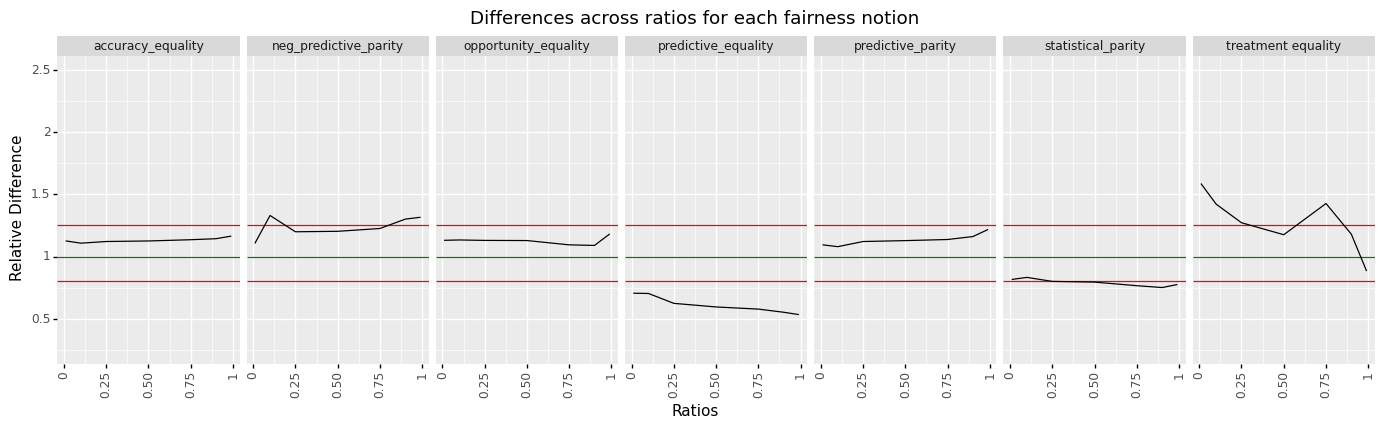

<ggplot: (166861344711)>

In [41]:
# check change in ratio averaged over all classifier
d = rel_diff.groupby(["criterion", "ratio"], as_index = False)["diff"].mean()

plot =  (p9.ggplot(data = d, mapping = p9.aes(x = 'ratio', y = 'diff'))
        + p9.geom_hline(yintercept = 0.8, color = "red")
        + p9.geom_hline(yintercept = 1, color = "green")
        + p9.geom_hline(yintercept = 1.25, color = "red")
        + p9.geom_line()
        + p9.facet_grid(".~criterion")
        + p9.coords.coord_cartesian(ylim = (0.25, 2.5))
        + p9.theme(axis_text_x = p9.element_text(angle = 90), figure_size = (17, 4))
        + p9.labs(x = "Ratios", y = "Relative Difference", title = ("Differences across ratios for each fairness notion avg"))
)

#plot.save(filename="plots/timeseries/timeseries_clf_avg.jpg")  
plot

In [42]:
# check change in ratio averaged over all fairness definitions
d = rel_diff.groupby(["classifier", "ratio"], as_index = False)["diff"].mean()

plot =  (p9.ggplot(data = d, mapping = p9.aes(x = "ratio", y = "diff"))
        + p9.geom_hline(yintercept = 0.8, color = "red")
        + p9.geom_hline(yintercept = 1, color = "green")
        + p9.geom_hline(yintercept = 1.25, color = "red")
        + p9.geom_line()
        + p9.facet_grid(".~classifier")
        + p9.coords.coord_cartesian(ylim = (0.25, 2.5))
        + p9.theme(axis_text_x = p9.element_text(angle = 90), figure_size = (17, 4))
        + p9.labs(x = "Ratios", y = "Relative Difference", title = ("Average differences across ratios for each classifier"))
)
# plot.save(filename="plots/timeseries/criterion_avg.jpg")  

In [43]:
# # check changes in ratio per classifier per criterion
d = rel_diff.groupby(["classifier", "criterion", "ratio"], as_index = False)["diff"].mean()

plot =  (p9.ggplot(data = d, mapping = p9.aes(x = "ratio", y = "diff", color = "criterion"))
        + p9.geom_hline(yintercept = 0.8, color = "red")
        + p9.geom_hline(yintercept = 1, color = "green")
        + p9.geom_hline(yintercept = 1.25, color = "red")
        + p9.geom_line()
        + p9.facet_grid(".~classifier")
        + p9.coords.coord_cartesian(ylim = (0.25, 2.5))
        + p9.theme(axis_text_x = p9.element_text(angle = 90), figure_size = (17, 4))
        + p9.labs(x = "Ratios", y = "Relative Difference", title = ("Differences across ratios for each classifier"))
)

#plot.save(filename="plots/timeseries/clf_criterion.jpg")  

In [44]:
# same as above but treatment equality is removed
rel_diff2 = rel_diff.copy()
ind = rel_diff2.loc[rel_diff2["criterion"] == "treatment equality"].index.to_list()
rel_diff2.drop(ind, inplace = True)
d = rel_diff2.groupby(["classifier", "ratio"], as_index = False)["diff"].mean()

plot =  (p9.ggplot(data = d, mapping = p9.aes(x = "ratio", y = "diff"))
        + p9.geom_hline(yintercept = 0.8, color = "red")
        + p9.geom_hline(yintercept = 1, color = "green")
        + p9.geom_hline(yintercept = 1.25, color = "red")
        + p9.geom_line()
        + p9.facet_grid(".~classifier")
        + p9.coords.coord_cartesian(ylim = (0.25, 2.5))
        + p9.theme(axis_text_x = p9.element_text(angle = 90), figure_size = (17, 4))
        + p9.labs(x = "Ratios", y = "Relative Difference", title = ("Average differences across ratios for each classifier"))
)

#plot.save(filename="plots/timeseries/without_treatment_eq.jpg")  

## Extra: Train natural distribution

In [ ]:
# train with natural distribution:
dataframes   = [df_adult, df_german, df_default, df_ricci, df_disease, df_failure, df_student]
transformers = [pipe_adult, pipe_german, pipe_default, pipe_ricci, pipe_disease, pipe_failure, pipe_student]
classifiers  = [KNeighborsClassifier(5), SVC(), GaussianNB(), DecisionTreeClassifier(random_state = 99),
                RandomForestClassifier(random_state = 99), AdaBoostClassifier(), 
                XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss')]    

predictions_nat = {}

for i in range (0, 7):                                                                                            
    dataframe_predictions_nat = {}
    dataframe = dataframes[i].copy()
    data_name = data_names[i]
    
    transformer = transformers[i]
    transformer.fit(dataframe.drop("CLASS", axis = 1, inplace = False))  
    
    #create balanced test set and super training set
    df_0, df_1 = dataframe.loc[dataframe["PRTCTD_ATTR"] == "unpriv"], dataframe.loc[dataframe["PRTCTD_ATTR"] == "priv"]    
    tst_size = math.floor(min(df_0.shape[0], df_1.shape[0]) * 0.2)
    train_size = min(df_0.shape[0], df_1.shape[0]) - tst_size
    df_0_train, df_0_test, y0, y0_test = train_test_split(df_0.drop("CLASS", axis = 1), df_0["CLASS"],
                                                          test_size = tst_size, shuffle = True, random_state = 99             
                                                         )
    df_1_train, df_1_test, y1, y1_test = train_test_split(df_1.drop("CLASS", axis = 1), df_1["CLASS"], 
                                                          test_size = tst_size, shuffle = True, random_state = 99              
                                                         )
    
    df_test = pd.concat([df_0_test, df_1_test])
    y_test = pd.concat([y0_test, y1_test])
    out = pd.concat([df_test["PRTCTD_ATTR"], y_test], axis = 1)
    X_test = transformer.transform(df_test)
    
    for classifier in classifiers:
        clf_name = classifier.__class__.__name__
        rto_predictions_nat = {}
        
        rto = round(dataframe.loc[dataframe["PRTCTD_ATTR"] == "unpriv"].size / dataframe.size, 2)
        rto_predictions_nat[rto] = out.copy()
    
        for seed in range(1, 31):     
            df_0_cop = df_0_train.copy()   
            df_1_cop = df_1_train.copy()
            # create biased training set by downsizing and upsizing the unpriv group vs. priv group
            df_0_sub = df_0_cop.sample(n = math.floor(rto * train_size), replace = False, random_state = seed)             
            df_1_sub = df_1_cop.sample(n = train_size - math.floor(rto * train_size), replace = False, random_state = seed) 
            df_train = pd.concat([df_0_sub, df_1_sub])
            y = pd.concat([y0, y1]).loc[df_train.index.to_list()]
   
            X = transformer.transform(df_train)
                
            #cv = cross_val_score(classifier, X, y, cv = 5, scoring = 'accuracy').mean()
            classifier.fit(X, y)
            pred = classifier.predict(X_test)             
            rto_predictions_nat[rto][seed] = pred
            classifier = clone(classifier) 
                
            # to check results: rto_predictions[rto]["SUM"] = rto_predictions[rto].sum(axis = 1)
                
        dataframe_predictions_nat[clf_name] = rto_predictions_nat
    
    predictions_nat[data_name] = dataframe_predictions_nat

In [ ]:
data_names = ["df_adult", "df_german", "df_default", "df_ricci", "df_disease", "df_failure", "df_student"]
classifier_names = ["KNeighborsClassifier", "GaussianNB", "SVC", "DecisionTreeClassifier",
                    "RandomForestClassifier", "AdaBoostClassifier", "XGBClassifier"]

ratios_nat = [0.32, 0.31, 0.6, 0.43, 0.32, 0.35, 0.59]
results_nat = {}

for j in range (0, 7):
    data_name = data_names[j]
    df_results_nat = {}

    for clf_name in classifier_names:
        rto = ratios_nat[j]
        rto_results_nat = {}

        attr_results_nat = {}                                                     
        df_pred_nat = predictions_nat[data_name][clf_name][rto]
            
        for group in ("unpriv", "priv"):   
            group_results_nat = {}
            df_pred_attr_nat = df_pred_nat.loc[df_pred_nat["PRTCTD_ATTR"] == group]
            TP, TN, FP, FN = 0, 0, 0, 0
            size, pos_pred, neg_pred = 0, 0, 0

            for i in range(1, 31):           
                confusion = confusion_matrix(df_pred_attr_nat["CLASS"], df_pred_attr_nat[i])
                TP += confusion[1, 1]
                TN += confusion[0, 0]
                FP += confusion[0, 1]
                FN += confusion[1, 0]
                size += confusion.sum()

            group_results_nat["TP"] = TP
            group_results_nat["TN"] = TN
            group_results_nat["FP"] = FP
            group_results_nat["FN"] = FN
            group_results_nat["size"] = size

            group_results_nat["accuracy_equality"] = division((TP + TN), size)
            group_results_nat["opportunity_equality"] = division(TP, (TP + FN))
            group_results_nat["predictive_equality"] = division(FP, (TN + FP))
            group_results_nat["predictive_equality"] = division(FP, (TN + FP))
            group_results_nat["statistical_parity"] = division((TP + FP), size)
            group_results_nat["predictive_parity"] = division(TP, (TP + FP))
            group_results_nat["neg_predictive_parity"] = division(TN, (TN + FN))
            group_results_nat["treatment equality"] = division(division(FP, (TN + FP)), division(FN, (TP + FN)))
                
            attr_results_nat[group] = group_results_nat
            
        rto_results_nat[rto] = pd.DataFrame(attr_results_nat)
        rto_results_nat[rto]["SUM"] = rto_results_nat[rto].sum(axis = 1)   # calculate sum for overall performance
        df_results_nat[clf_name] = rto_results_nat

    results_nat[data_name] = df_results_nat

In [ ]:
rel_diff_nat = pd.DataFrame(columns = ["dataset", "classifier", "ratio", "criterion", "diff"])

for i in range(0,7):
    data_name = data_names[i]
    for clf_name in classifier_names:
        rto = ratios_nat[i]
        for criterion in criteria:
            diff = division(results_nat[data_name][clf_name][rto]["unpriv"][criterion],
                              results_nat[data_name][clf_name][rto]["priv"][criterion])
            rel_diff_nat.loc[len(rel_diff_nat)] = [data_name, clf_name, rto, criterion, diff]

In [ ]:
# boxplot per criterion per classifier for natural distribution
d = rel_diff_nat.groupby(["criterion", "classifier"], as_index = False)["diff"]

plot = (p9.ggplot(data = d, mapping = p9.aes(x = "classifier", y = "diff"))
        + p9.geom_hline(yintercept = 0.8, color = "red")
        + p9.geom_hline(yintercept = 1, color = "green")
        + p9.geom_hline(yintercept = 1.25, color = "red")
        + p9.geom_boxplot(color = "black", fill = "darkgrey")
        + p9.coords.coord_cartesian(ylim = (0, 3))
        + p9.facet_grid(".~criterion")#, space = "free_x", scales = "fixed")
        + p9.theme(axis_text_x = p9.element_text(angle = 90), figure_size = (17, 4))
        + p9.labs(x = "ML Models", y = "Relative Difference", title = ("Boxplots of Ratio for all ML models"))
        )

#plot.save(filename = "plots/boxplots/boxplot_natural.jpg")   